##Chapters


1.    Dataset Access & Preprocessing
-  Load 3,000 images and their corresponding binary masks.
-   Resize images to 512x512 for better efficiency.
-  Normalize pixel values to [0,1].
- Apply data augmentation for better generalization.


2.   U-Net Model with Attention Mechanism

Implement the U-Net architecture with Attention Gates to refine segmentation.
Use skip connections to retain spatial information.

3. Training & Optimization
Compile the model with Binary Cross-Entropy Loss + Dice Coefficient.
Train for 10-20 epochs with Adam optimizer.

4. Evaluation & Metrics
Compute IoU (Intersection over Union) and Dice Score.
Validate results on test images.

5. Predictions & Visualization
Display original images, ground truth masks, and model predictions.


##**Download Dataset**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!mkdir -p /content/dataset
!kaggle datasets download -d balraj98/deepglobe-road-extraction-dataset -p /content/dataset --unzip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset URL: https://www.kaggle.com/datasets/balraj98/deepglobe-road-extraction-dataset
License(s): other
100% 3.78G/3.79G [00:17<00:00, 283MB/s]
100% 3.79G/3.79G [00:17<00:00, 228MB/s]


##**Library Imports**

In [2]:
import os
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, Activation, Multiply, Add, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

##**Load Dataset Information**

In [3]:
# Load metadata CSV
metadata_path = "/content/dataset/metadata.csv"
df = pd.read_csv(metadata_path)

# Load class dictionary
class_dict_path = "/content/dataset/class_dict.csv"
class_df = pd.read_csv(class_dict_path)
class_names = class_df['name'].tolist()
class_colors = class_df[['r', 'g', 'b']].values.tolist()
num_classes = len(class_names)

# Limit dataset to 3,000 images
df = df[:3000]

## **Data Preprocessing**

In [4]:
IMG_SIZE = 512  # Resize to 512x512

def preprocess_image(image_path):
    # Ensure the correct absolute path
    full_path = os.path.join("/content/dataset", image_path)

    if not os.path.exists(full_path):  # Check if file exists
        print(f"Warning: File {full_path} not found.")
        return np.zeros((IMG_SIZE, IMG_SIZE, 3))  # Return a blank image instead

    img = cv2.imread(full_path, cv2.IMREAD_COLOR)

    if img is None:
        print(f"Error: Could not read {full_path}")
        return np.zeros((IMG_SIZE, IMG_SIZE, 3))  # Return a blank image

    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0  # Normalize
    return img


def preprocess_mask(mask_path):
    full_path = os.path.join("/content/dataset", mask_path)

    if not os.path.exists(full_path):
        print(f"Warning: File {full_path} not found.")
        return np.zeros((IMG_SIZE, IMG_SIZE, num_classes))  # Return blank mask

    mask = cv2.imread(full_path, cv2.IMREAD_COLOR)

    if mask is None:
        print(f"Error: Could not read {full_path}")
        return np.zeros((IMG_SIZE, IMG_SIZE, num_classes))  # Return blank mask

    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    one_hot_mask = np.zeros((IMG_SIZE, IMG_SIZE, num_classes), dtype=np.uint8)

    for i, color in enumerate(class_colors):
        match = np.all(mask == color, axis=-1)
        one_hot_mask[match, i] = 1  # Assign class index

    return one_hot_mask



# Load dataset
images = np.array([preprocess_image(img_path) for img_path in df['sat_image_path']])
masks = np.array([preprocess_mask(mask_path) for mask_path in df['mask_path']])


### **Visualize Data**

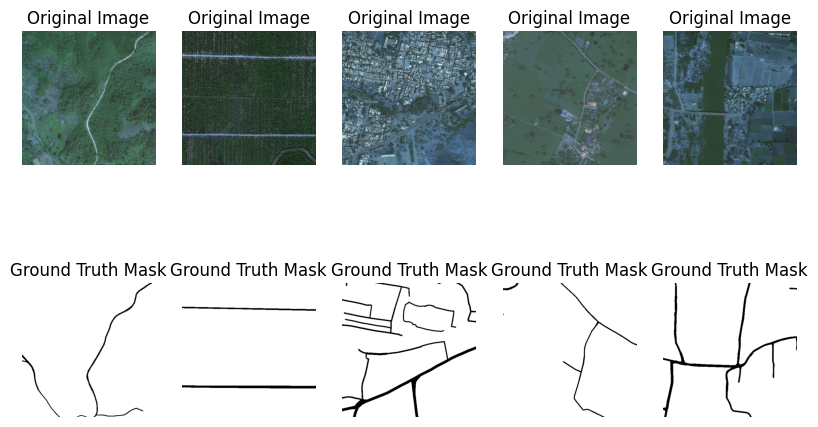

In [5]:
plt.figure(figsize=(10, 6))
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i])
    plt.axis("off")
    plt.title("Original Image")

    plt.subplot(2, 5, i+6)
    plt.imshow(np.argmax(masks[i], axis=-1), cmap='gray')
    plt.axis("off")
    plt.title("Ground Truth Mask")

plt.show()

### **Data Splitting & Augmentation**

In [7]:
def data_generator(image_datagen, mask_datagen, batch_size=8):
    image_gen = image_datagen.flow(train_images, batch_size=batch_size, seed=42)
    mask_gen = mask_datagen.flow(train_masks, batch_size=batch_size, seed=42)

    while True:
        image_batch = next(image_gen)
        mask_batch = next(mask_gen)

        # Ensure masks are properly one-hot encoded
        if len(mask_batch.shape) == 3:  # If mask shape is (512,512), expand dimensions
            mask_batch = np.expand_dims(mask_batch, axis=-1)  # Add channel dimension
            mask_batch = tf.keras.utils.to_categorical(mask_batch, num_classes=num_classes)  # One-hot encoding

        yield (image_batch, mask_batch)

# Define Data Augmentation before calling data_generator
data_gen_args = dict(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1,
                     zoom_range=0.1, horizontal_flip=True)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args, preprocessing_function=lambda x: np.argmax(x, axis=-1))

# Ensure train_images and train_masks are defined before passing them
train_images, test_images, train_masks, test_masks = train_test_split(images, masks, test_size=0.2, random_state=42)

# Create Train Generator
train_generator = data_generator(image_datagen, mask_datagen, batch_size=8)

# Model Evaluation and Predictions
def evaluate_and_predict(model, test_images, test_masks):
    loss, accuracy = model.evaluate(test_images, test_masks)
    print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")
    predictions = model.predict(test_images)
    plt.imshow(np.argmax(predictions[i], axis=-1), cmap='gray')


    # Visualize Predictions
    plt.figure(figsize=(10, 6))
    for i in range(3):
        plt.subplot(3, 3, i+1)
        plt.imshow(test_images[i])
        plt.axis("off")
        plt.title("Original Image")

        plt.subplot(3, 3, i+4)
        plt.imshow(np.argmax(test_masks[i], axis=-1), cmap='gray')
        plt.axis("off")
        plt.title("Ground Truth Mask")

        plt.subplot(3, 3, i+7)
        plt.imshow(np.argmax(predictions[i], axis=-1), cmap='gray')
        plt.axis("off")
        plt.title("Predicted Mask")
    plt.show()

    return predictions

print("Full multi-class segmentation pipeline with U-Net and attention is ready!")


Full multi-class segmentation pipeline with U-Net and attention is ready!


#**U-Net Model with Attention Mechanism**

In [8]:
def attention_block(x, skip, filters):
    g = Conv2D(filters, (1,1), padding="same")(x)
    s = Conv2D(filters, (1,1), padding="same")(skip)
    attention = Add()([g, s])
    attention = Activation("relu")(attention)
    attention = Conv2D(1, (1,1), padding="same", activation="sigmoid")(attention)
    return Multiply()([skip, attention])

def unet_attention(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    inputs = Input(input_shape)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    up5 = UpSampling2D(size=(2,2))(conv4)
    att5 = attention_block(up5, conv3, 256)
    merge5 = concatenate([up5, att5], axis=3)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(merge5)
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(conv5)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


##**Model Training**

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = unet_attention()

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')
]

history = model.fit(
    train_generator,
    validation_data=(test_images, test_masks),
    steps_per_epoch=len(train_images) // 8,
    validation_steps=len(test_images) // 8,
    epochs=20,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (2400, 512, 512, 2) (2 channels).
  warnings.warn(


ValueError: could not broadcast input array from shape (512,512) into shape (512,512,2)